[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for MNIST
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [5]:
import sys

In [6]:
sys.path

['/home/xykong/private/dsc180a-2023-fa/dsc-capstone-b05-q1/playground',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages/IPython/extensions',
 '/home/xykong/.ipython']

In [7]:
sys.path.insert(1, '/home/xykong/private/dsc180a-2023-fa/dsc-capstone-b05-q1')

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
# from model import DDPM
from model import MyTinyUNet
from etl import show_images
# from etl import generate_image
from unet import UNet
from full_unet import FullUNet

In [9]:
import os

In [10]:
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        # creating a 1-d tensor of size num_timesteps
        # setting variances betas
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        # let alpha = 1 - beta at each timestep
        self.alphas = 1.0 - self.betas
        # this is the cumulative product of all alphas - this will be used on image at t when getting image at t+1
        # the vector alphas_cumprod will have size num_timesteps, still in 1-d
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        # sqrt_alphas_cumprod will have size num_timesteps
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        # sqrt_one_minus_alphas_cumprod will have size num_timesteps
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]
        # the new shape of s1 and s2 will be (timesteps, 1, 1, 1)
        s1 = s1.reshape(-1, 1, 1, 1)
        s2 = s2.reshape(-1, 1, 1, 1)
        return x_start*s1 + x_noise*s2

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample, noise_type, params):
        """
        This function is one step of sampling (algorithm 2 in DDPM paper)
        As we loop through t = T, ..., 1, we will call this method
        
        @param model_output is the predicted epsilon, noise added to the current sample, which is x_{t}
        @param timestep is the current timestep we are at
        @param sample is the current sample, x_{t}
        @return a prediction of the previous sample, x_{t-1}
        """
        # one step of sampling
        # this is algorithm 2 - sampling, for each t, do..
        # timestep (1)
        t = timestep
        # coef_epsilon is a 1-d tensor with size (timestep)
        coef_epsilon = (1-self.alphas[t])/self.sqrt_one_minus_alphas_cumprod[t]
        coef_epsilon = coef_epsilon.reshape(-1, 1, 1, 1)
        coef_first = 1/(self.alphas[t]**0.5)
        coef_first = coef_first.reshape(-1, 1, 1, 1)
        # x_{t-1} without the variance
        pred_prev_sample = coef_first*(sample - coef_epsilon*model_output)
        
        variance = 0
        if t > 0:
            # Returns a tensor with the same size as input that is 
            # filled with random numbers from a specific distribution
#             z = torch.randn_like(sample).to(self.device)
            z = generate_noise(noise_type, sample.shape, params).to(self.device)
            variance = (self.betas[t] ** 0.5)*z
            
        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample

In [13]:
def generate_image(ddpm, sample_size, channel, size, device, noise_type="Gaussian", params=None):
    """Generate the image from noise given noise type. Default is Gaussian noise"""
    frames = []
    frames_mid = []
    ddpm.eval()
    batch_shape = torch.Size([sample_size, channel, size, size])
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        print(len(timesteps))
#         sample = generate_noise(noise_type, batch_shape, params)
        sample = torch.randn(sample_size, channel, size, size).to(device)
    
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample, noise_type, params)

            if t==len(timesteps)/2:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [14]:
class LaplaceNLL(nn.Module):
    def __init__(self, scale = 1.0):
        super(LaplaceNLL, self).__init__()
        self.scale = scale
    
    def forward(self, x, target):
        log = torch.log(torch.tensor([2*self.scale])).to(device)
        nll_loss = torch.sum(log + torch.abs(x-target)/self.scale, dim=-1)
        nll_loss = torch.mean(nll_loss)
        return nll_loss

In [15]:
def generate_distribution(distribution_name, params=None):
    valid_distribution = {"Gaussian", "Laplace"}
    if distribution_name not in valid_distribution:
        raise Exception(f"'distribution' not of value {valid_distribution}")
    
    loc = 0.0
    scale = 1.0
        
    if params:
        try:
            loc = params['loc']
            scale = params['scale']
        except KeyError as error:
            raise Exception(f"'params' is not properly initialized. It should contain 'loc' and 'scale' of the distribution")
    
    if not isinstance(loc, float):
        raise Exception("'loc' must be float")
        
    if not isinstance(scale, float):
        raise Exception("'scale' must be float")
            
    if distribution_name == "Gaussian":
        # normal gaussian, a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 
        dist = torch.distributions.Normal(torch.tensor([loc]), torch.tensor([scale]))
        
    elif distribution_name == "Laplace":
        dist = torch.distributions.Laplace(torch.tensor([loc]), torch.tensor([scale]))
        
    return dist

In [16]:
def generate_noise(noise_distribution, batch_shape, params=None):
    noise_distribution_allowed = {"Gaussian", "Laplace", "S&P"}
    if noise_distribution not in noise_distribution_allowed:
        raise Exception(f"'noise_distribution' not of value {noise_distribution_allowed}")
    
    if noise_distribution == "S&P":
        salt_mask = torch.randn(batch_shape).to(device) < 0.01
        pepper_mask = (torch.randn(batch_shape).to(device) < 0.01) & ~salt_mask # so that we select spot that salt hasn't been added to
        noise = (salt_mask.float() + pepper_mask.float()*-1).to(device)
    
    else:
        noise = generate_distribution(noise_distribution, params).expand(batch_shape).sample().to(device)
        
    return noise

In [17]:
def calc_loss(loss_f, pred, actual):
    
    if loss_f == "LaplaceNLL":
        criterion = LaplaceNLL()
    elif loss_f == "L1":
        criterion = nn.L1Loss()
    elif loss_f == "MSE":
        criterion = nn.MSELoss()
    elif loss_f == "NLL":
        criterion = nn.NLLLoss()
    elif loss_f == "Sigmoid":
        criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(pred, actual)
        
    return loss

In [18]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device, noise_type="Gaussian", loss_f="MSE"):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
   
    for epoch in range(num_epochs):
        model.train() # what does this do? train() is built-in?
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            # put batch to device (gpu or cpu) to leverage computational resources
            batch = batch[0].to(device) # batch.shape = torch.Size([4096, 1, 32, 32])
            
            # create noise
            actual_noise = generate_noise(noise_type, batch.shape)
            
            # Generates random timesteps for each sample in the batch. 
            # These timesteps determine at which diffusion step the noise is added. 
            # The num_timesteps parameter specifies the total number of diffusion steps.
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0], )).long().to(device)
            
            # returns x_{t+1}, a noisy image
            noisy = model.add_noise(batch, actual_noise, timesteps)
            
            # gives the noisy image and returns a prediction of the noise added
            noise_pred = model.reverse(noisy, timesteps) # torch.Size([4096, 1, 32, 32])
            
            loss = calc_loss(loss_f, noise_pred, actual_noise)
            
            # reset the gradient to zero before computing the new gradient in the backward pass
            optimizer.zero_grad()
            
            # Computes the gradients of the loss with respect to the model parameters. 
            # These gradients are used to update the model weights during optimization.
            loss.backward()
            
            # updates the parameters
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()

In [19]:
root_dir = './data/'
transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor()
        ])
dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1200, shuffle=True, num_workers=12)

In [20]:
dataloader

In [21]:
def generate_image(ddpm, sample_size, channel, size, device, noise_type="Gaussian", params=None):
    """Generate the image from noise given noise type. Default is Gaussian noise"""
    frames = []
    frames_mid = []
    ddpm.eval()
    
    batch_shape = torch.Size([sample_size, channel, size, size])
    print(batch_shape)
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        print(len(timesteps))
#         sample = generate_noise(noise_type, batch_shape, params)
        sample = torch.randn(sample_size, channel, size, size).to(device)
    
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample, noise_type, params)

            if t==len(timesteps)/2:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

# Running DDPM

In [ ]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
# network = MyTinyUNet()
# network = UNet(image_channels=1)
network = FullUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)      

In [30]:
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)  

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
generated, generated_mid = generate_image(model, 100, 1, 32, device)

torch.Size([100, 1, 32, 32])
1000


  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
# Note that generated and generated_mid are list object
len(generated), len(generated_mid)

(100, 100)

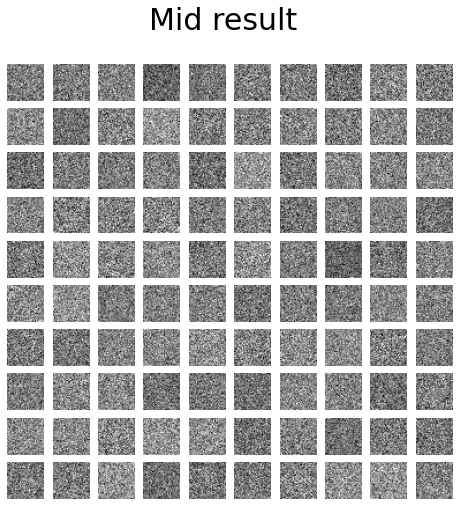

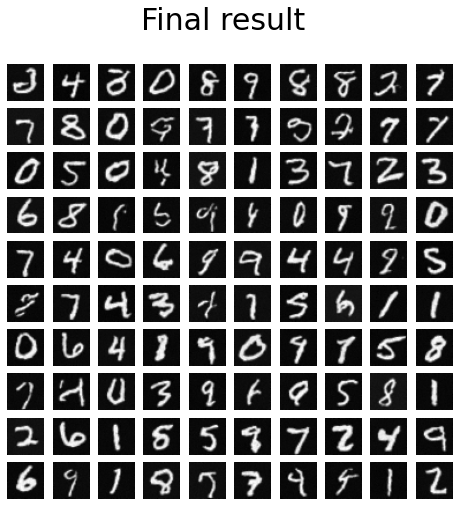

In [33]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")

# Aside

The `MyTinyUNet` is a versy small implementation of a convolutional UNet where a time embedding has been added at each step. To make things simple, we need to have an image of size $s\times s$ with $s$ divisible by 8 (this is why we will increase the size of the MNIST dataset from $28\times 28$ to $32 \times 32$).

In [ ]:
bs = 3
x = torch.randn(bs,1,32,32)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1, size=32)

In [ ]:
y = unet(x,timesteps)
y.shape

In [ ]:
salt_mask = torch.randn(1, 1, 32, 32) < 0.01
pepper_mask = (torch.randn(1, 1, 32, 32) < 0.01) & ~salt_mask # so that we select spot that salt hasn't been added to
sample = (salt_mask.float() + pepper_mask.float()*-1)
sample_G = torch.randn(1, 1, 32, 32)

In [ ]:
show_images(sample_G), show_images(sample)

### DDPM Original

In [ ]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, sample_distribution="Gaussian", param=None, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        # creating a 1-d tensor of size num_timesteps
        # setting variances betas
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        # let alpha = 1 - beta at each timestep
        self.alphas = 1.0 - self.betas
        # this is the cumulative product of all alphas - this will be used on image at t when getting image at t+1
        # the vector alphas_cumprod will have size num_timesteps, still in 1-d
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        # sqrt_alphas_cumprod will have size num_timesteps
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        # sqrt_one_minus_alphas_cumprod will have size num_timesteps
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]
        # according to the solution, this is for broadcasting? why?
        # the new shape of s1 and s2 will be (timesteps, 1, 1, 1)
        s1 = s1.reshape(-1, 1, 1, 1)
        s2 = s2.reshape(-1, 1, 1, 1)
        return x_start*s1 + x_noise*s2

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        """
        This function is one step of sampling (algorithm 2 in DDPM paper)
        As we loop through t = T, ..., 1, we will call this method
        
        @param model_output is the predicted epsilon, noise added to the current sample, which is x_{t}
        @param timestep is the current timestep we are at
        @param sample is the current sample, x_{t}
        @return a prediction of the previous sample, x_{t-1}
        """
        # one step of sampling
        # this is algorithm 2 - sampling, for each t, do..
        # timestep (1)
        t = timestep
        # coef_epsilon is a 1-d tensor with size (timestep)
        coef_epsilon = (1-self.alphas[t])/self.sqrt_one_minus_alphas_cumprod[t]
        coef_epsilon = coef_epsilon.reshape(-1, 1, 1, 1)
        coef_first = 1/(self.alphas[t]**0.5)
        coef_first = coef_first.reshape(-1, 1, 1, 1)
        # x_{t-1} without the variance
        pred_prev_sample = coef_first*(sample - coef_epsilon*model_output)
        
        variance = 0
        if t > 0:
            # Returns a tensor with the same size as input that is 
            # filled with random numbers from a normal distribution 
            # with mean 0 and variance 1
#             z = torch.randn_like(sample).to(self.device)
#             z = Laplace(torch.tensor([0.0]), torch.tensor([1.0])).expand(sample.shape).sample().to(device)
            salt_mask = torch.randn(sample.shape) < 0.01
            pepper_mask = (torch.randn(sample.shape) < 0.01) & ~salt_mask # so that we select spot that salt hasn't been added to
            z = (salt_mask.float() + pepper_mask.float()*-1).to(device)
            variance = (self.betas[t] ** 0.5)*z
            
        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample

In [ ]:
for b in dataloader:
    batch = b[0]
    what_is_b = b # b[0] is the image tensor, b[1] is the label
    break

print(batch.shape)
bn = [b for b in batch[:100]] # taking first 100 images from the pool of images - total 4096 images

In [ ]:
show_images(bn, "origin")

### Testing salt & pepper noise

In [ ]:
plt.imshow(bn[0].permute(1,2,0).numpy())

In [ ]:
salt_mask = torch.rand_like(bn[0]) < 0.01
pepper_mask = (torch.rand_like(bn[0]) < 0.01) & ~salt_mask # so that we select spot that salt hasn't been added to

In [ ]:
salt_mask_num = salt_mask.float()
pepper_mask_num = pepper_mask.float()*-1

In [ ]:
salt_mask_num + pepper_mask_num

In [ ]:
test = bn[0].clone().detach()

In [ ]:
test[salt_mask] = 1
test[pepper_mask] = -1

In [ ]:
plt.imshow(test.permute(1,2,0).numpy(), cmap="gray")

#### Testing LaplaceNLL class

In [ ]:
laplace_noise1 = Laplace(torch.tensor([0.0]), torch.tensor([2.0])).expand(batch.shape).sample().to(device)
laplace_noise2 = Laplace(torch.tensor([0.0]), torch.tensor([2.0])).expand(batch.shape).sample().to(device)

In [ ]:
batch.shape

In [ ]:
torch.log(torch.tensor([100]))

In [ ]:
LaplaceNLL()(laplace_noise1, laplace_noise2)

In [ ]:
torch.nn.L1Loss()(laplace_noise1, laplace_noise2)

You can check that all the parameters of the UNet `network` are indeed parameters of the DDPM `model` like this:

In [ ]:
# Note how the first size has changed to the new timesteps defined above, which is great
for n, p in model.named_parameters():
    print(n, p.shape)

In [ ]:
# To check memory usage
!nvidia-smi

In [ ]:
# looks like repeated timesteps are allowed?
timesteps = torch.randint(0, num_timesteps, (batch.shape[0], )).long().to(device) 
timesteps.shape

#### Why do we allow repeated timesteps?

Allowing repeated timesteps in the same batch is a common practice in various machine learning scenarios. It introduces additional stochasticity into the training process, which can help the model generalize better to different data patterns. Each sample in the batch effectively experiences a different diffusion process, adding diversity to the training data and encouraging the model to learn a more robust representation of the underlying data distribution.

In the context of the Denoising Diffusion Probabilistic Model (DDPM), allowing repeated timesteps helps the model learn to handle different diffusion steps for different samples in the same batch, simulating the stochastic nature of the diffusion process in real-world data.

### Random stuffs

In [ ]:
a = torch.arange(4.)
b = a.reshape(-1, 1, 1, 1)
b, b.shape

In [ ]:
a = torch.arange(4.)
b = a.reshape(-1, 2, 2, 1)
b, b.shape

In [ ]:
a = torch.arange(4.)
b = torch.arange(4.)
((a+1)/(b+1)).shape

The commands below are here to help you and to test your code.

In [ ]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [ ]:
timesteps

In [ ]:
betas.shape

In [ ]:
betas[timesteps]

In [ ]:
betas[10]

In [ ]:
betas[timesteps].reshape(-1,1,1,1).shape

In [ ]:
network = MyTinyUNet(in_c =1, out_c =1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [ ]:
bs = 5
x = torch.randn(bs,1,32,32).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [ ]:
x, timesteps

In [ ]:
timesteps.shape

In [ ]:
y = model.add_noise(x,x,timesteps)
y.shape

In [ ]:
y = model.step(x,timesteps[0],x)
y.shape

In [ ]:
laplace_noise = Laplace(torch.tensor([0.0]), torch.tensor([1.0])).expand(torch.Size([4096, 1, 32, 32]))
laplace_noise.sample()

In [ ]:
noise = torch.randn(torch.Size([4096, 1, 32, 32]))
noise